Image Normalization
Image Resizing
pair Generation **bold text**

In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

1. **Data Collection**

In [2]:
!git clone https://github.com/ahussain-ai/SiamNetSignature.git

fatal: destination path 'SiamNetSignature' already exists and is not an empty directory.


2. **Dataset Preprocessing**

In [3]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import os
import glob
import random
from itertools import combinations, product

In [4]:
dataset_dir = "/content/SiamNetSignature/signatures"

In [5]:

forged = {}

for idx in range(1, 56):
    files = glob.glob(f"{dataset_dir}/full_forg/forgeries_{idx}_*.*")
    forged[f"forged_{idx}"] = files

originals = {}
for idx in range(1, 56):
    files = glob.glob(f"{dataset_dir}/full_org/original_{idx}_*.*")
    originals[f"original_{idx}"] = files

In [6]:
def read_image(path):
    # Read the image from the file
    img = tf.io.read_file(path)

    # Decode the image as a grayscale image
    img = tf.image.decode_image(img, channels=1)

    # Resize the image to the desired size (112, 112)
    img = tf.image.resize(img, [105, 105])

    # Convert image to uint8 (if necessary)
    img = tf.cast(img, tf.uint8)

    return img

def read_image_pair(tup) :

    """read image pair one by one"""
    img1 , img2 = tup
    return read_image(img1), read_image(img2)

In [7]:
# Function to plot pairs of images
def plot_image_pairs(image_pairs,label_1 ='Original', label_2 ='forged', num_cols=2):
    fig = plt.figure(figsize=(16, 8))
    rows = len(image_pairs)
    columns = 2

    for idx, (img1, img2) in enumerate(image_pairs):
        # Adds a subplot at the idx position
        ax1 = fig.add_subplot(rows, columns, 2*idx + 1)
        ax2 = fig.add_subplot(rows, columns, 2*idx + 2)

        # showing image
        ax1.imshow(img1)
        ax1.axis('off')
        ax1.set_title(label_1)

        # showing image
        ax2.imshow(img2)
        ax2.axis('off')
        ax2.set_title(label_2)

    plt.show()

In [8]:
def pair_generate(original, forged, num_pairs =  200 ) :

    """generate pair from two list by taking one of each

    Arguments

        original --> list of images containing original signature of the writer
        forged --> list of images containing forged signatures of the writer
        num_pair --> number of pairs for each writer

    returns -->
        anchor --> List of tuples containing two original signature from the writer
        negative --> ............................one original and one forged

    """

    anchor = []
    negative = []

    anc_ = random.sample ( list ( combinations(original, 2) ), num_pairs)
    neg_ =  random.sample( list(product(original, forged)), num_pairs)



    anchor = list ( map(read_image_pair, anc_) )
    negative = list ( map (read_image_pair, neg_) )


    return anchor, negative

def pair(original, forged) :

    """
    Arguments :

     original --> Dictionary containing  paths to the original signature of each writer ( 55 writer having 24 signatures each)
     forged --> Dictionary contained paths to the forged signature of each writer ( 55 writer having 24 signatures each)

    Returns :
    anchor, anchor_y : original signature pair with label of each [1,1,1,...  ]
    negative, negative_y: forged signature pair, with label [0,0,0,......]

    """

    anchor = []
    negative = []

    for key1, key2 in zip(original, forged) :
        anc, neg =  pair_generate(original[key1], forged[key2])
        anchor.extend( anc )
        negative.extend( neg )

    anchor_y = np.ones(len(anchor))
    negative_y = np.zeros(len(negative))

    return ( anchor, anchor_y ), (negative, negative_y)

In [9]:
(anchor, anchor_y), ( negative, negative_y) = pair(originals, forged)

In [10]:
print(f'Total pair in anchor {len(anchor)}')
print(f'Total pair in negative {len(negative)}')

Total pair in anchor 11000
Total pair in negative 11000


In [11]:
random.shuffle(anchor)
random.shuffle(negative)

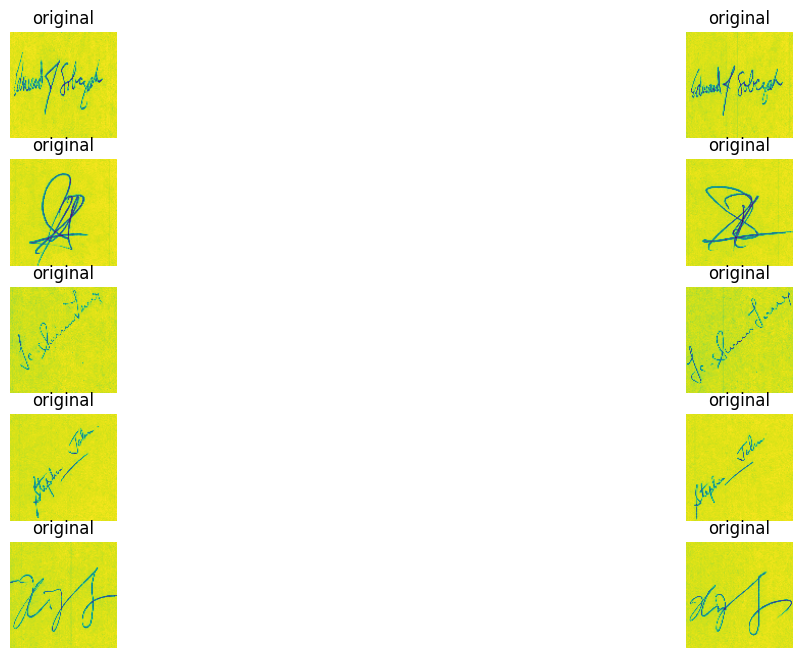

In [12]:

plot_image_pairs(anchor[:5], label_1='original', label_2='original')

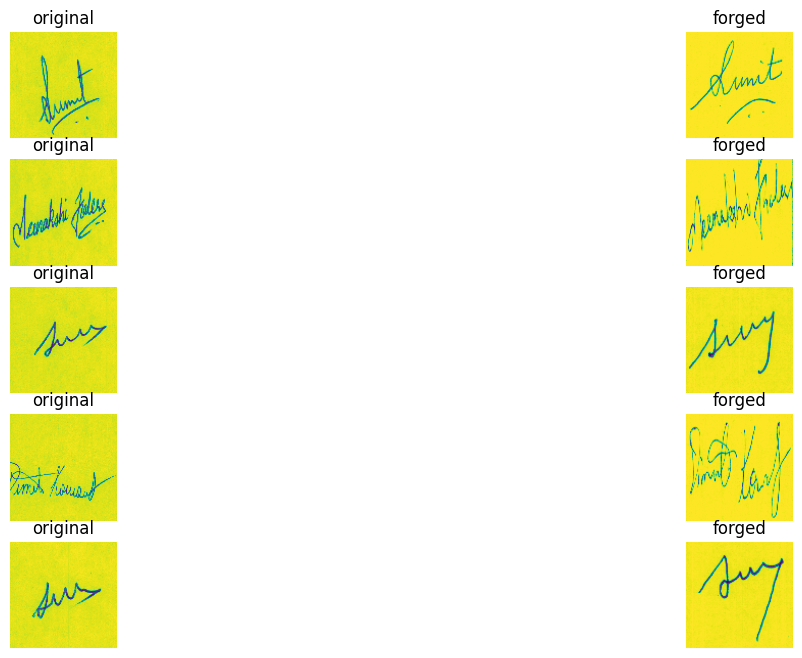

In [13]:
plot_image_pairs(negative[:5], label_1='original', label_2='forged')

**Tf Data Pipeline**

1. **Convert the anchor and negative list into tf data datset format**
2. **Zip the anchor and anchor_label , negative and negative_label**
3. **Cocate the anchor set and negative set**

In [14]:
anchor_images_1 = np.array([pair[0] for pair in anchor])
anchor_images_2 = np.array([pair[1] for pair in anchor])

negative_images_1 = np.array([pair[0] for pair in negative])
negative_images_2 = np.array([pair[1] for pair in negative])


# Concatenate for the final model input
X_anchor = [anchor_images_1, anchor_images_2]
X_negative = [negative_images_1, negative_images_2]

# Combine anchor and negative data
all_images_1 = np.concatenate([anchor_images_1, negative_images_1], axis=0)
all_images_2 = np.concatenate([anchor_images_2, negative_images_2], axis=0)
all_labels = np.concatenate([anchor_y, negative_y], axis=0)

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(((all_images_1, all_images_2), all_labels))

# Shuffle, batch, and prefetch the dataset
dataset = dataset.shuffle(buffer_size=2*len(anchor))
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Split Data into train and set**

In [15]:
train_size = int(0.8 * len(anchor) * 2)
test_size = len(anchor)*2 - train_size

In [16]:
print(train_size)
print(test_size)

17600
4400


In [17]:
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [18]:
train_dataset = train_dataset.batch(128)
test_dataset = test_dataset.batch(32)

In [19]:
#check if the shuffled occured correctly or not

sample_iterator = train_dataset.take(1).as_numpy_iterator()
# for i, sample in enumerate(sample_iterator):
#     images, label = sample
#     image1, image2 = images
#     print(f"Sample {i+1}: Image shape: {image1.shape},{image2.shape} Label: {label}")

In [20]:
images, labels = sample_iterator.next()

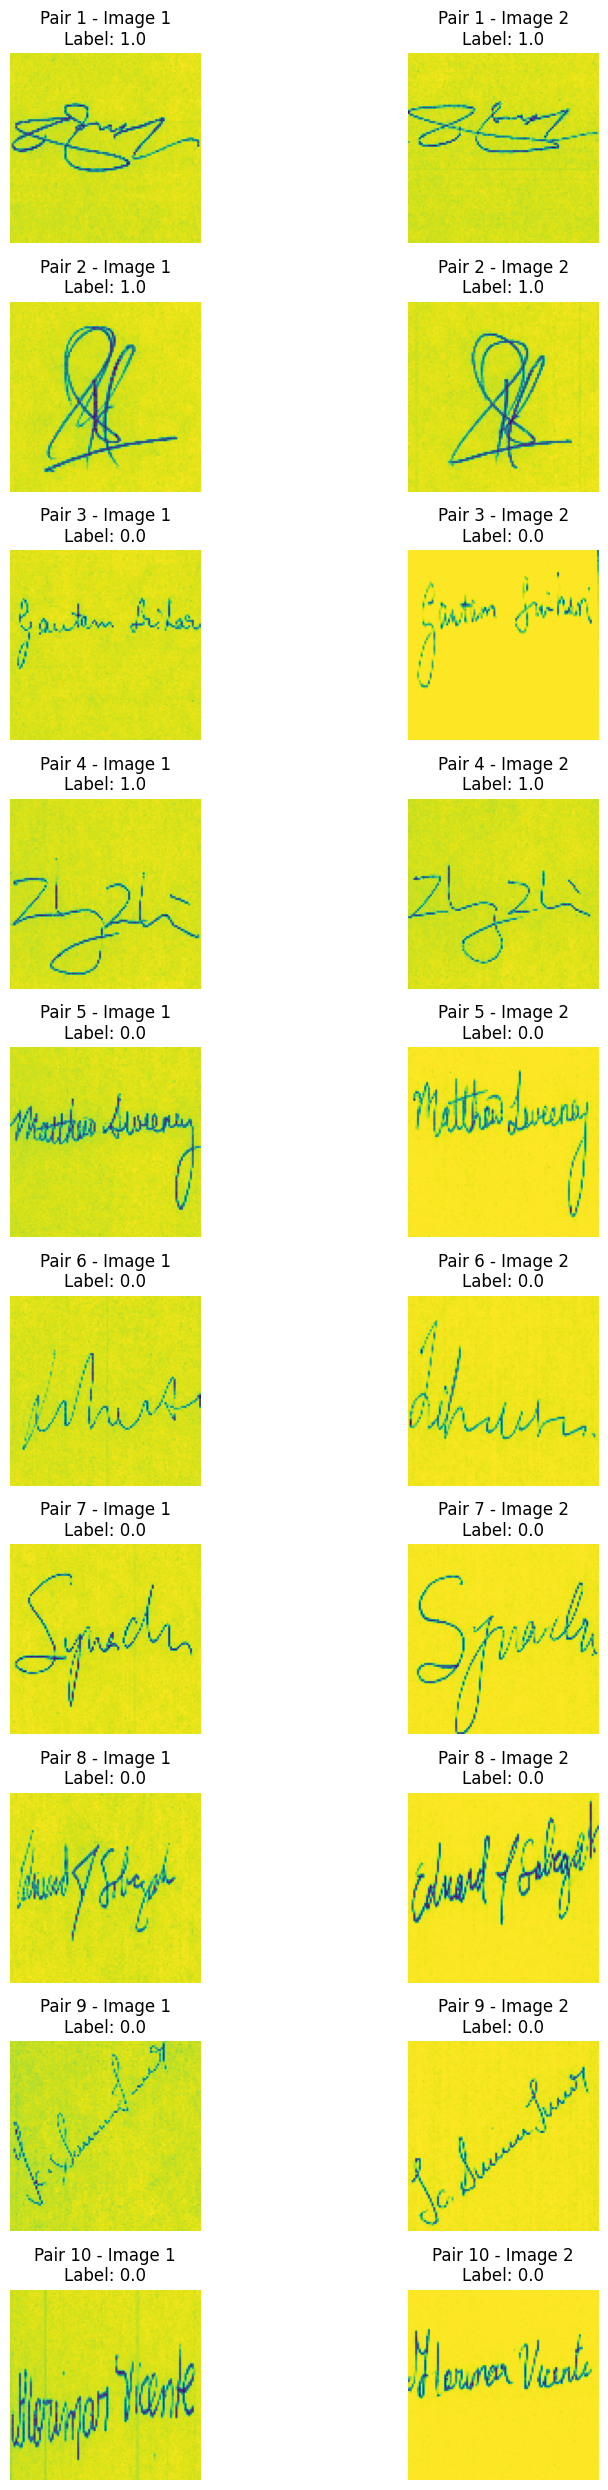

In [33]:
# Plot the images with labels
def plot_batch(images, labels):

    max_len = len(labels)
    fig, axes = plt.subplots(10, 2, figsize=(10, 10 * 2.5))

    image1 , image2 = images
    for i in range(10):
        # Plot the first image in the pair
        ax = axes[i, 0]
        ax.imshow(tf.squeeze(image1[i]))
        ax.set_title(f"Pair {i+1} - Image 1\nLabel: {labels[i]}")
        ax.axis('off')

        # Plot the second image in the pair
        ax = axes[i, 1]
        ax.imshow(tf.squeeze(image2[i]))
        ax.set_title(f"Pair {i+1} - Image 2\nLabel: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_batch(images, labels)

**Model Building**

/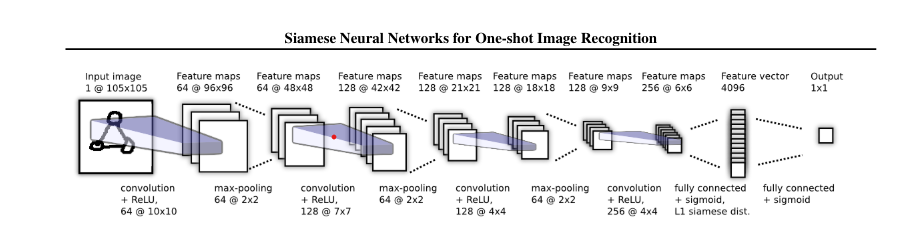

We will be creating a variation of actual siamese base model, but the core idea remain same

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda

In [23]:


def build_base_network(input_shape):

    input = Input(shape=input_shape)

    #block 1
    x = Conv2D(64, (3, 3),activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2),strides = 2)(x)

    #block 2
    x = Conv2D(128, (3, 3),activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2),strides = 2)(x)

    #block 3
    x = Conv2D(256, (3, 3),activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2),strides = 2)(x)

    #block 3
    x = Conv2D(128, (3, 3),activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2),strides = 2)(x)

    #block 4
    x = Conv2D(128, (4, 4))(x)
    x = Flatten()(x)

    X = Dense(4096, activation='relu')(x)

    return Model(input, X)


class L1Dist(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        super(L1Dist, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, embedding_a, embedding_b):
        #avoid 0 difference
        return tf.math.abs(embedding_a - embedding_b) + self.epsilon


def make_siamese_model() :

  input_shape = (105,105,1)
  base_network = build_base_network(input_shape)
  print(base_network.summary())

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  distance_layer = L1Dist()
  distance = distance_layer(processed_a, processed_b)

  dense = Dense(1, activation ='sigmoid')(distance)

  model = Model([input_a, input_b], dense)
  return model

In [24]:
model = make_siamese_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105, 105, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 103, 103, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 51, 51, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 256)       295168

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 105, 105, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 4096)                 1455360   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 l1_dist (L1Dist)            (None, 4096)                 0         ['model[0][0]',         

In [26]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Mean

**Training**

In [27]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.
    """

    def __init__(self, siamese_network):
        super().__init__()
        self.siamese_network = siamese_network
        self.acc_tracker = BinaryAccuracy(name="accuracy")
        self.loss_tracker = Mean(name="loss")
        self.loss_fn = BinaryCrossentropy()

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        (images1, images2), actual = data

        with tf.GradientTape() as tape:
            predicted = self.siamese_network([images1, images2])
            loss = self.loss_fn(actual, predicted)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(actual, predicted)
        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    def test_step(self, batch):
        (images1, images2), actual = batch

        predicted = self.siamese_network([images1, images2])
        loss = self.loss_fn(actual, predicted)

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(actual, predicted)
        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [28]:
siamese_model = SiameseModel(model)
siamese_model.compile(optimizer= Adam())
history = siamese_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
138/138 [==============================] - 42s 209ms/step - loss: 0.2949 - accuracy: 0.8419 - val_loss: 0.0918 - val_accuracy: 0.9705
Epoch 2/5
138/138 [==============================] - 23s 165ms/step - loss: 0.0665 - accuracy: 0.9742 - val_loss: 0.0273 - val_accuracy: 0.9909
Epoch 3/5
138/138 [==============================] - 23s 166ms/step - loss: 0.0235 - accuracy: 0.9918 - val_loss: 0.0433 - val_accuracy: 0.9832
Epoch 4/5
138/138 [==============================] - 23s 165ms/step - loss: 0.0420 - accuracy: 0.9846 - val_loss: 0.0273 - val_accuracy: 0.9905
Epoch 5/5
138/138 [==============================] - 24s 168ms/step - loss: 0.0378 - accuracy: 0.9870 - val_loss: 0.0226 - val_accuracy: 0.9934


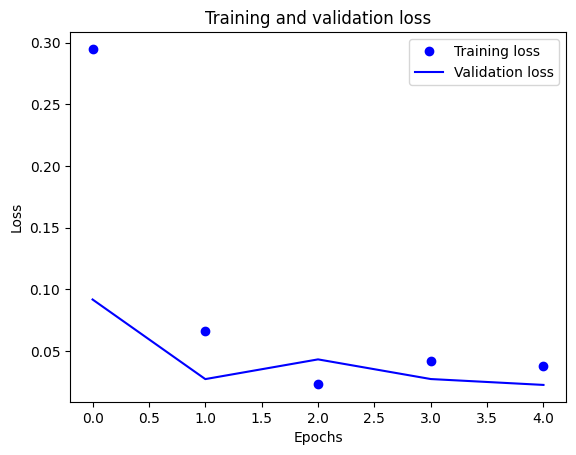

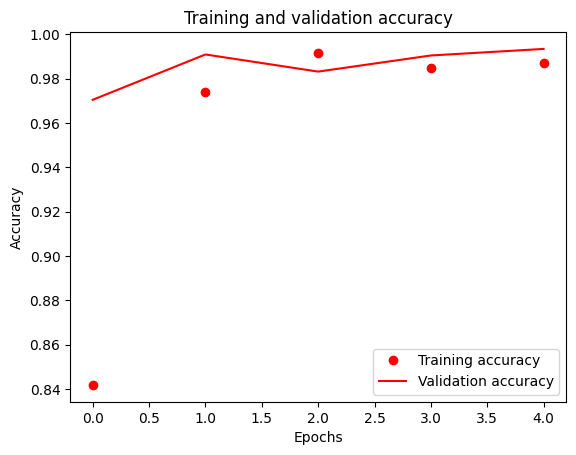

In [29]:

def plot_history(history):
  """
  This function visualizes the training and validation loss and accuracy of a Keras model.

  Args:
    history: A Keras history object.
  """
  losses = history.history["loss"]
  val_losses = history.history["val_loss"]
  accuracies = history.history["accuracy"]
  val_accuracies = history.history["val_accuracy"]
  epochs = range(len(losses))

  # Plot the training and validation loss
  plt.figure()
  plt.plot(epochs, losses, "bo", label="Training loss")
  plt.plot(epochs, val_losses, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Plot the training and validation accuracy
  plt.figure()
  plt.plot(epochs, accuracies, "ro", label="Training accuracy")
  plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

plot_history(history)

In [30]:

def evaluate(model, test_data):
    """
    This function evaluates a Keras model on a test dataset.

    Args:
        model: A Keras model.
        test_data: A tf.data.Dataset object containing the test data.

    Returns:
        A tuple of (loss, accuracy, precision, recall) values.
    """
    loss = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.BinaryAccuracy()
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()

    for images, labels in test_data:
        predictions = model(images)
        # Reshape labels to match predictions shape
        labels = tf.reshape(labels, (-1, 1))
        loss(tf.keras.losses.binary_crossentropy(labels, predictions))
        accuracy.update_state(labels, predictions)
        precision.update_state(labels, predictions)
        recall.update_state(labels, predictions)

    return loss.result(), accuracy.result(), precision.result(), recall.result()

# Assuming model and test_dataset are already defined
loss, accuracy, precision, recall = evaluate(model, test_dataset)
f1_score = 2* (precision*recall)/(precision+recall)
print(f"Loss: {loss:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
print(f"F1 score {f1_score}")


Loss: 0.02, Accuracy: 0.99, Precision: 1.00, Recall: 0.99
F1 score 0.9926773309707642


[[2231    0]
 [  32 2137]]


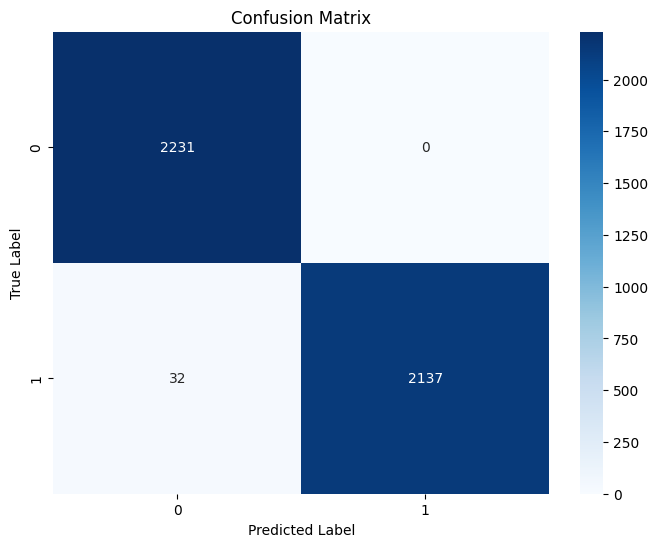

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_data):
    """
    This function plots the confusion matrix of a Keras model on a test dataset.

    Args:
        model: A Keras model.
        test_data: A tf.data.Dataset object containing the test data.
    """
    # Get predictions and labels
    predictions = []
    labels = []
    for images, label in test_data:

        predictions.extend(model(images).numpy())
        labels.extend(label.numpy())

    # Convert predictions to binary values
    predictions = np.where(np.array(predictions) > 0.5, 1, 0)

    # Create and plot the confusion matrix
    cm = confusion_matrix(labels, predictions)
    print(cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_dataset)